In [1]:
import xarray as xr 
import numpy as np
import gsw as gsw
import OCAPE_functions_xarray as Of_xr #A is the residu of 'Annual'
from scipy.optimize import linear_sum_assignment
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [29]:
long_min=90
long_max=270
lat_min=80
lat_max=90
M=250

ds_sal = xr.open_dataset(r"C:\\Users\\titou\\OneDrive\\Bureau\\ocape_computation\\ANNUAL_LEVITUS\\anual_sal.nc")
ds_temp = xr.open_dataset(r"C:\\Users\\titou\\OneDrive\\Bureau\\ocape_computation\\ANNUAL_LEVITUS\\anual_temp.nc")


In [30]:
press_bis_AX = -ds_temp.Z
longitude_AX = ds_temp.X
latitude_AX = ds_temp.Y

press = xr.apply_ufunc(gsw.conversions.p_from_z, press_bis_AX, latitude_AX)
abs_sal_3dz = xr.apply_ufunc(gsw.conversions.SR_from_SP, ds_sal)
Ctemp_3dz = xr.apply_ufunc(gsw.conversions.CT_from_t, abs_sal_3dz.sal, ds_temp, press)

c:\Users\titou\Anaconda3\envs\Stage_M1\lib\site-packages\gsw\_utilities.py:70: RuntimeWarning: invalid value encountered in cast
  newargs.append(np.asarray(arg, dtype=float))


In [31]:
#Slice the original data to conserved only the considered latitudes and longitudes
lat_AX=latitude_AX.sel(Y=slice(lat_min, lat_max))
long_AX=longitude_AX.sel(X=slice(long_min, long_max))

N_CT_3d = Ctemp_3dz.sel(Y=slice(lat_min, lat_max), X=slice(long_min, long_max))
Nabs_sal_3dz = abs_sal_3dz.sel(Y=slice(lat_min, lat_max), X=slice(long_min, long_max))


press_to_interpol = press.sel(Y=lat_max, method='nearest')


In [32]:
press_AX = xr.DataArray(np.linspace(0, press.sel(Y=slice(lat_min, lat_max)).max(), M), dims=["press"])
P = press_AX.expand_dims({'X':len(Nabs_sal_3dz.X),'Y':len(Nabs_sal_3dz.Y)  })

In [33]:
ds = Nabs_sal_3dz
# Define the new press_bis axis (50 points)
press_bis = press_AX.values
press_bis_broadcasted = xr.DataArray(
    np.broadcast_to(press_bis, (len(ds['X']), len(ds['Y']), len(press_bis))),
    dims=['X', 'Y', 'press_bis'],
    coords={'X': ds['X'], 'Y': ds['Y'], 'press_bis': press_bis}
)

In [34]:
CTofP=Of_xr.interpolate_xarray(N_CT_3d, press_bis_broadcasted)
ASofP=Of_xr.interpolate_xarray(Nabs_sal_3dz, press_bis_broadcasted)

In [35]:
# Reshape using expand_dims to prepare for broadcasting
aS1_expanded = ASofP.sal.expand_dims({'press_bis_2': M}, axis=1)  # Shape becomes (M, 1)
cT_expanded = CTofP.temp.expand_dims({'press_bis_2': M}, axis=1)  # Shape becomes (M, 1)
P_expanded = press_bis_broadcasted.expand_dims({'press_bis_2': M}).rename({'press_bis': 'press_bis_2', 'press_bis_2': 'press_bis'}) # Shape becomes (1, M)
# Compute the enthalpy matrix using broadcasting
enthalpy_matrix = gsw.energy.enthalpy(aS1_expanded,cT_expanded, P_expanded)
enthalpy_from_vec=gsw.energy.enthalpy(ASofP.sal, CTofP.temp, press_bis_broadcasted)

# Apply the function across all (lat, lon) combinations
result = xr.apply_ufunc(
    Of_xr.compute_rpe_single_ignore_nan,
    enthalpy_matrix,
    input_core_dims=[["press_bis", "press_bis_2"]],
    output_core_dims=[[],["rows_result"], ["cols_result"]],
    vectorize=True,
    dask="allowed",  # Enables compatibility with lazy computation
    output_dtypes=[float,int,int],
)

rpe_all=result[0]
iPE=enthalpy_from_vec.mean(dim='press_bis')
reduced_APE = iPE-rpe_all/M

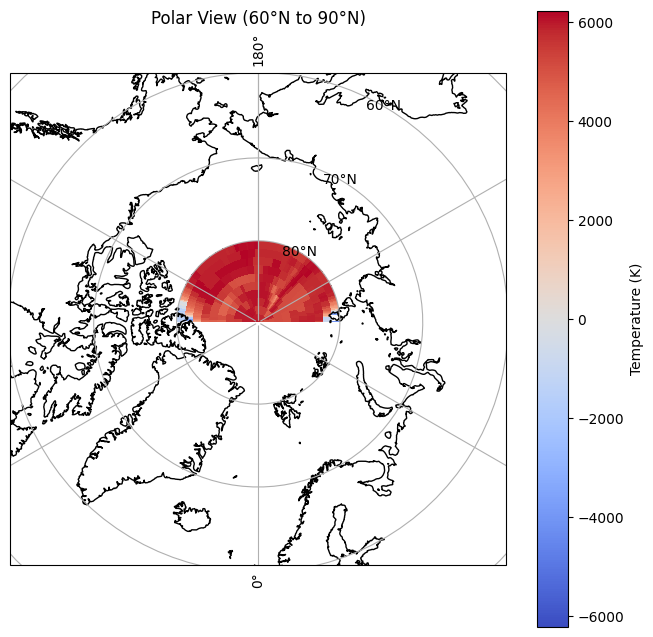

In [36]:
# Example xarray dataset with coordinates as latitude and longitude
# Replace this with your actual dataset
data = reduced_APE
# Define projection
projection = ccrs.NorthPolarStereo()  # Use SouthPolarStereo() for South Pole

# Create figure and axes
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(8, 8))

# Set extent: focus on the area from 60°N to 90°N
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# Plot the data
data.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Transform from lat/lon to projection
    cmap='coolwarm',
    add_colorbar=True,
    cbar_kwargs={'label': 'Temperature (K)'}
)

# Add features like coastlines and gridlines
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

# Crop the map to a circle by focusing only on the polar area

plt.title("Polar View (60°N to 90°N)")
plt.show()
